# Class overlap: continuation

This notebook's goal is to extend the methods initiated in 

1. Build-up of a more automatic approach
2. Validation of the method
3. Generalization to unseen data
4. Extension to unseen data

In [423]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from mpl_toolkits.mplot3d import Axes3D
import gower
import prince
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, recall_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from collections import Counter
from typing import List
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from tqdm import tqdm
from scipy.spatial.distance import euclidean, hamming
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import BallTree
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
import scipy.stats

# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *
from auxFuns.class_overlap import *

In [422]:
import auxFuns.EDA 
importlib.reload(auxFuns.EDA)

import auxFuns.modelling
importlib.reload(auxFuns.modelling)

import auxFuns.class_overlap
importlib.reload(auxFuns.class_overlap)

<module 'auxFuns.class_overlap' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\class_overlap.py'>

In [4]:
# Load of the data and filter in the needed features

raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest_v2.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)

In [5]:
selected_features = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','month_of_the_test','multiple_tests',
                     'BPA','BPAI']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [6]:
df1 = rsv_predictors_df_v2[selected_features_v2]

df1.shape, df1.columns

((86058, 21),
 Index(['n_tests_that_day', 'sine', 'cosine', 'previous_test_daydiff',
        'Bronchitis', 'CCI', 'Acute_upper_respiratory_infection',
        'n_immunodeficiencies', 'n_symptoms', 'healthcare_seeking',
        'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
        'key_comorbidities', 'Pneumonia', 'season', 'month_of_the_test',
        'multiple_tests', 'BPA', 'BPAI', 'RSV_test_result'],
       dtype='object'))

# 0. Build up on an initial dataframe for visualization purposes

In [6]:
random_seed = 42
n_components = 5

X_all = df1.drop(['RSV_test_result'], axis = 1)

famd = prince.FAMD(n_components=n_components, random_state=random_seed)
famd = famd.fit(X_all)

df5_visualization = famd.transform(X_all)

# Ensure both df1 and df5_visualization present the same records in the same order
df1 = df1.sort_index()
df5_visualization = df5_visualization.sort_index()

assert all(df1.index == df5_visualization.index), "The indices of df1 and df5_visualization do not match."

df5_visualization['RSV_test_result'] = [1 if label == 'Positive' else 0 for label in df1['RSV_test_result']]

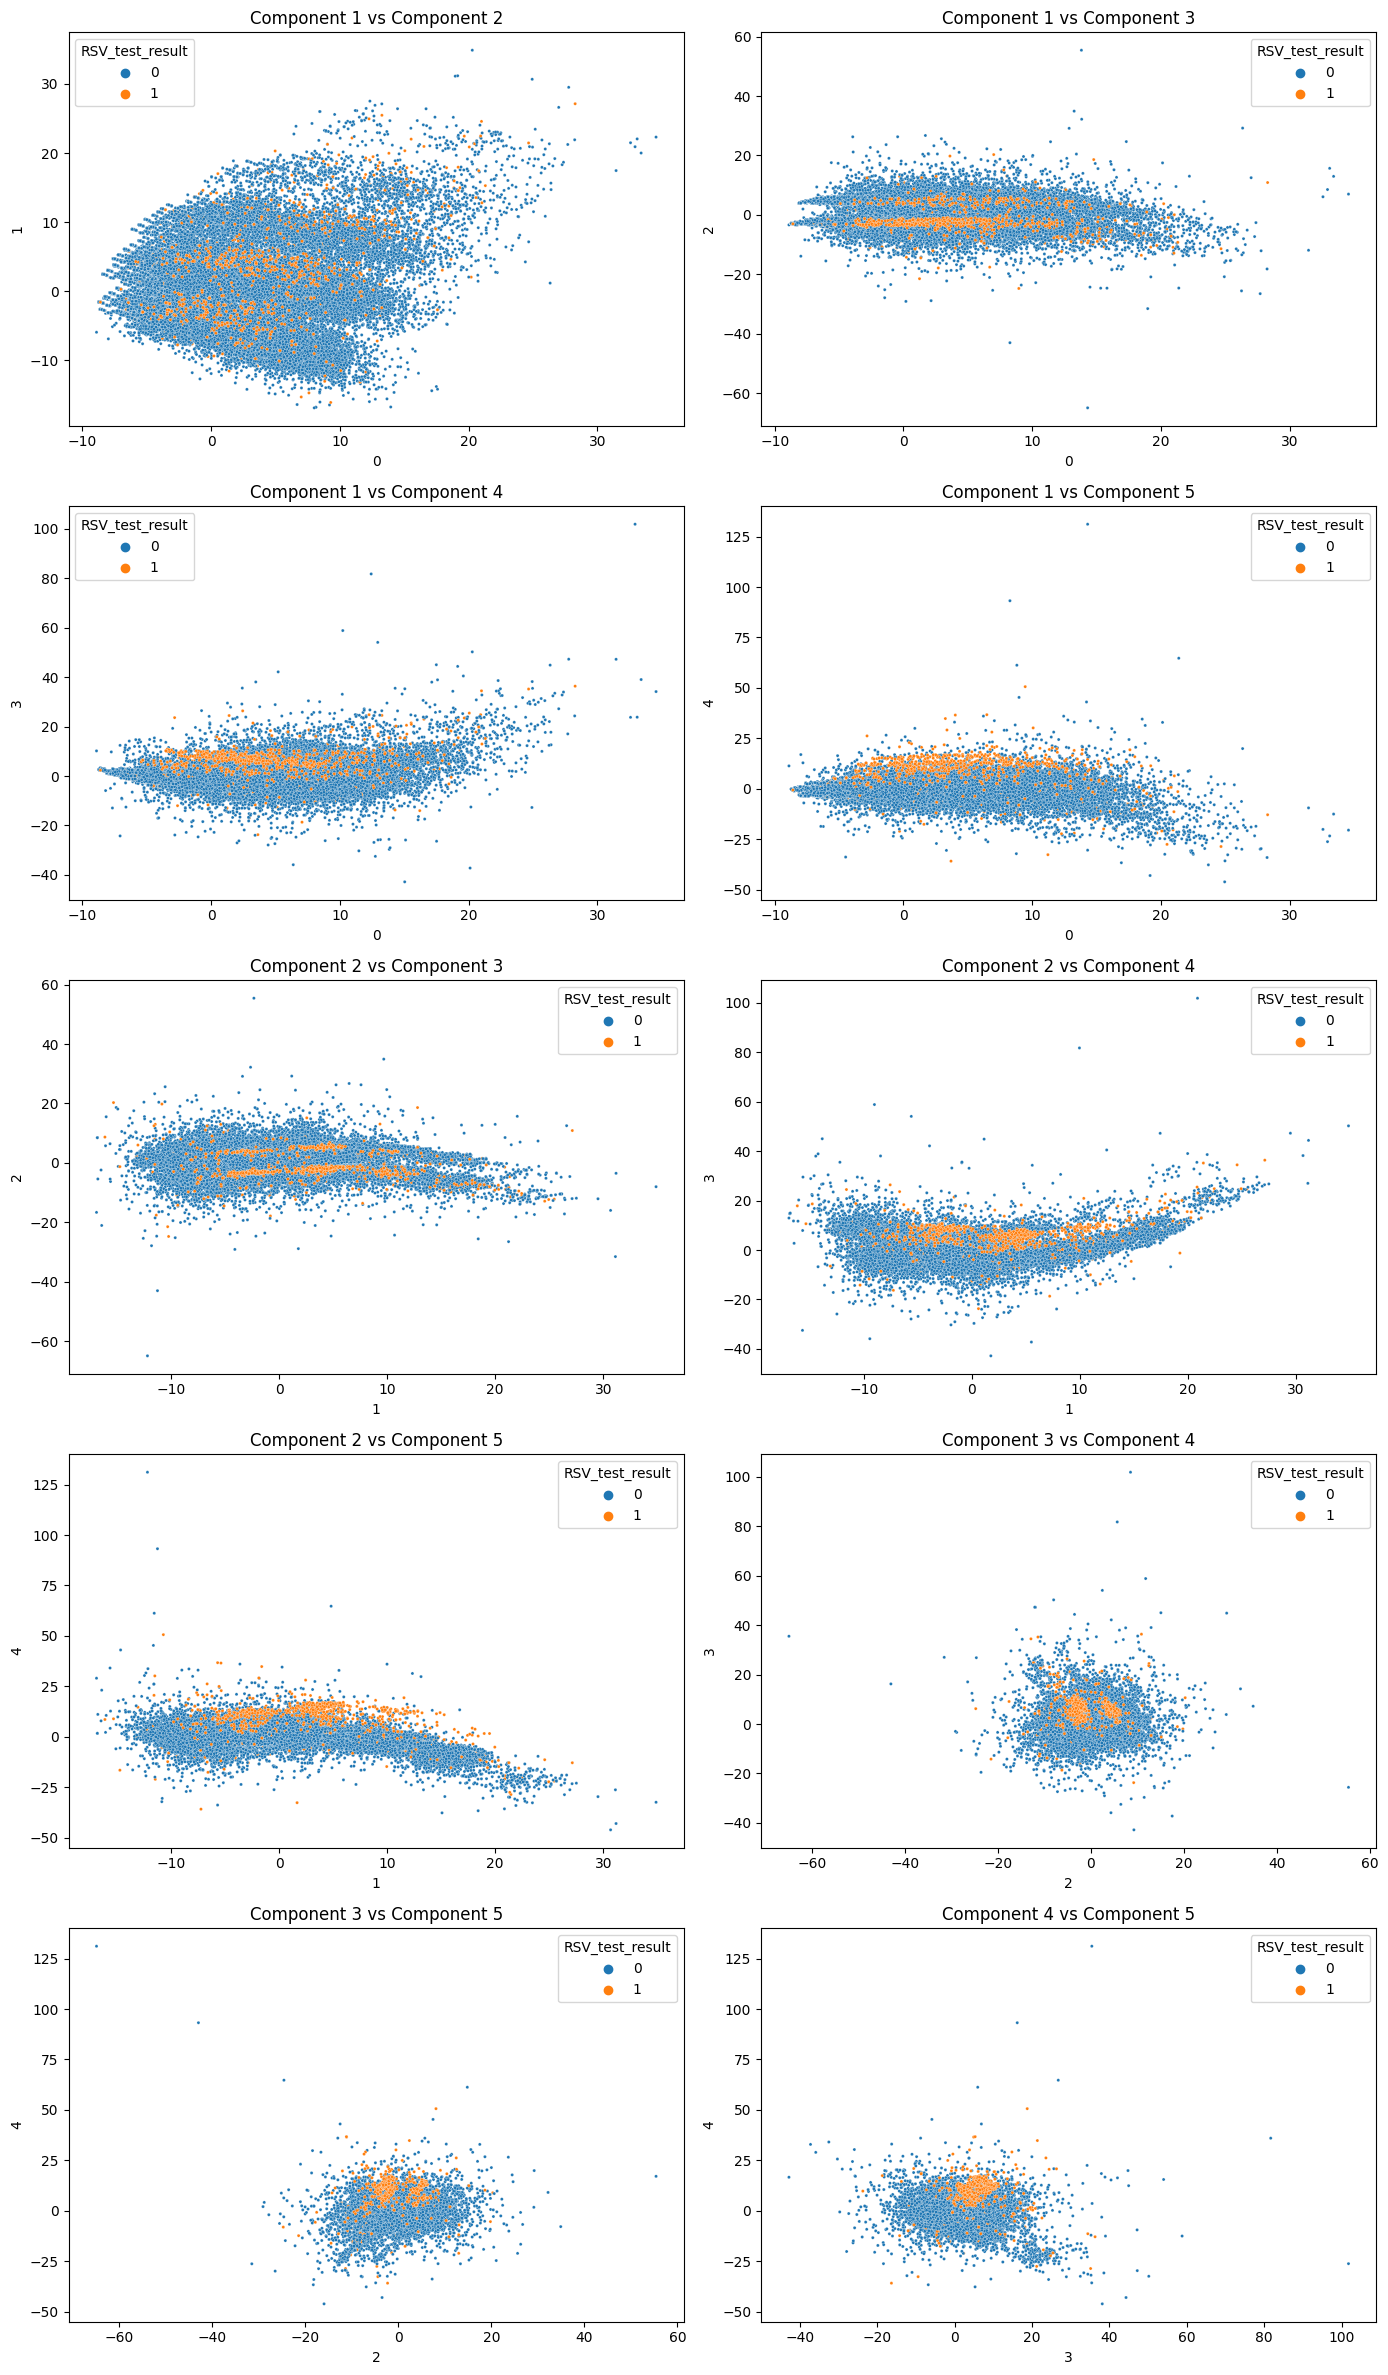

In [9]:
plot_5FMDA_planes(df=df5_visualization, hue_target = 'RSV_test_result', s_size = 5)

# 1. Build-up of a more automatic approach

In [10]:
# Validated intial process relies on three steps:
# 1. FAMD transform the data to a number of components = number of features in the data
# 2. Build-up of a ball tree 
# 3. Finding the nearest neighbour for every instance. Distance is defined structurally as the closest other instance in the tree
# 4. Determination of those instances where the closes neighbour is of the same class or not (and computation of N1 metric)

X_data = df1.drop(['RSV_test_result'], axis = 1)

# Step 1: FAMD transform
print('FAMD transforming the original data ...')

n_components = X_data.shape[1]
# n_components = 5

famd21 = prince.FAMD(n_components=n_components, random_state=random_seed)
famd21 = famd21.fit(X_data)

X_21famd = famd21.transform(X_data)

# Step 2: Ball tree 
print('Build-up of the ball tree ...')

tree = BallTree(X_21famd)

# Step 3: tree-guided closest neighbour
print('Finding closest neighbour in the ball tree for every instance ...')

# The closest point to every instance is itself, so k = 2 returns the point itself + the closest neighbour
dist, ind = tree.query(X_21famd, k=2)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')

labels = df1['RSV_test_result'].to_numpy()
same_class_neighbours = labels[ind[:, 0]] == labels[ind[:, 1]]
N1 = 1 - np.mean(same_class_neighbours)

print('Done!')

FAMD transforming the original data ...
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...


Having defined the initial method, there are several points of improvement.
- Famd dimensionality reduction : setting n_components to n_features may be overkilling it
- Ball tree: may be possible to build it with the original data directly, not needing to step through the famd transformation
- Extension of the N1 metric and impact in meta learning > adjust it to imbalanced settings
- Steps 1 and 3 are the bottlenecks of the process > find a way to make them faster

## Test 1: avoid FAMD analysis 

Build-up of the Ball tree using the original data directly

In [8]:
X_data = df1.drop(['RSV_test_result'], axis = 1)

# Step 0: No famd transform
print('TEST 1: Testing the process using non-famd transformed data ...')
X_data_dummies = pd.get_dummies(X_data)

# Step 2: Ball tree 
print('Build-up of the ball tree ...')

tree2 = BallTree(X_data_dummies)

# Step 3: tree-guided closest neighbour
print('Finding closest neighbour in the ball tree for every instance ...')

# The closest point to every instance is itself, so k = 2 returns the point itself + the closest neighbour
dist2, ind2 = tree2.query(X_data_dummies, k=2)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')

labels = df1['RSV_test_result'].to_numpy()
same_class_neighbours2 = labels[ind2[:, 0]] == labels[ind2[:, 1]]
N1_2 = 1 - np.mean(same_class_neighbours2)

print('Done!')

TEST 1: Testing the process using non-famd transformed data ...
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...
Done!


In [13]:
# The approaches identify different overlapping points
N1, N1_2

(0.043889005089590705, 0.045504194845336854)

In [9]:
# Evaluate performance of both approaches
# First: of approach 1 (yes FAMD)
print('\n------------------')
print('-------------------')
print('yes FAMD model')
model_nonOverlapping1, model_Overlapping1 = build_and_evaluate_2overlapping_models(df1 = df1, same_class_neighbors = same_class_neighbours, 
                                                                                   cost_sensitive_overlapping = False, cost_sensitive_non_overlapping = False)

# Second: of approach 2 (no FAMD)
print('\n------------------')
print('-------------------')
print('NO FAMD model')
model_nonOverlapping2, model_Overlapping2 = build_and_evaluate_2overlapping_models(df1 = df1, same_class_neighbors = same_class_neighbours2, 
                                                                                   cost_sensitive_overlapping = False, cost_sensitive_non_overlapping = False)



------------------
-------------------
NO FAMD model
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5617311594758091

----------------
Performance metrics of non-overlapping model ...
Optimal threshold: 0.19
Optimal f1: 0.5734767025089607


AUC Score: 0.9097236026094737
Precision / Positive predictive value: 1.0
Specificity: 1.0
Recall / sensitivity: 0.4020100502512563
Negative predictive value: 0.9927212673558016
Accuracy: 0.9927567106945037
F-1: 0.5734767025089607
Precision-Recall AUC: 0.49169845909352516
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5087620569894985

---------------

Both models give similar performance, with slight differences in recall and precisionnvalues:

- Model with no FAMD: better precision (0.572 7vs 0.555)
- Model with FAMD: better recall (0.748 vs 0.705)
- Results in very similar F1 scores: (0.631 vs 0.637)

Another interesting result is that, in both cases, when not applying cost-sensitive learning the results improve

In [14]:
# Save the models for later use
phase1_models_path = os.getcwd() + '/models/models_phase1'
dump(model_nonOverlapping2, phase1_models_path + '/nonOverlapping_rfc_8020_nofamd.joblib')
dump(model_Overlapping2, phase1_models_path + '/Overlapping_rfc_8020_nofamd.joblib')

['c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning/models/models_phase1/Overlapping_rfc_8020_nofamd.joblib']

## Test 2: N1 metric for class imbalance

To obtain more meaningful information about the N1 metric in imbalanced data sets, let us extend it to similar to an augmented R-value

[] Augmented R-value: Borsos, Z., Lemnaru, C., & Potolea, R. (2018). Dealing with overlap and imbalance: a new metric and approach. Pattern Analysis and Applications, 21, 381-395.

[] N1, N2, N3 metric: Ho, T. K., & Basu, M. (2002). Complexity measures of supervised classification problems. IEEE transactions on pattern analysis and machine intelligence, 24(3), 289-300.

In [8]:
# Extension of N1 for class imbalance:
print(f'Standard N1 metric (for non-FAMD approach): {N1_2}')

labels = df1.RSV_test_result
imb_ratio =  (labels == 'Negative').sum() /(labels == 'Positive').sum()

positives_mask = labels == 'Positive'
negatives_mask = labels == 'Negative'

N1_minority = 1 - np.mean(same_class_neighbours2[positives_mask])
N1_majority = 1 - np.mean(same_class_neighbours2[negatives_mask])

print(f'N1 metric for minority class (Positive label): {N1_minority}')
print(f'N1 metric for majority class (Positive label): {N1_majority}')

AugN1 = (1/(imb_ratio + 1)) * (N1_majority + imb_ratio*N1_minority) # defined so the N1 metric in minority is weighted according to the imb_ratio
print(f'Augmented  N1 metric (for non-FAMD approach): {AugN1}')


Standard N1 metric (for non-FAMD approach): 0.045504194845336854
N1 metric for minority class (Positive label): 0.6258477769404672
N1 metric for majority class (Positive label): 0.027037072562467013
Augmented  N1 metric (for non-FAMD approach): 0.6073806546575974


In [ ]:
# Possible extension to metrics N2 and N3, if determined to be of interest

## Test 3: identification of overlapping regions, rather than overlapping instances

At the moment, our approach is very much local: it detects instances which are considered to be 'overlapping'. Now I would like to see overlapping/non-overlapping **regions** rather than instances

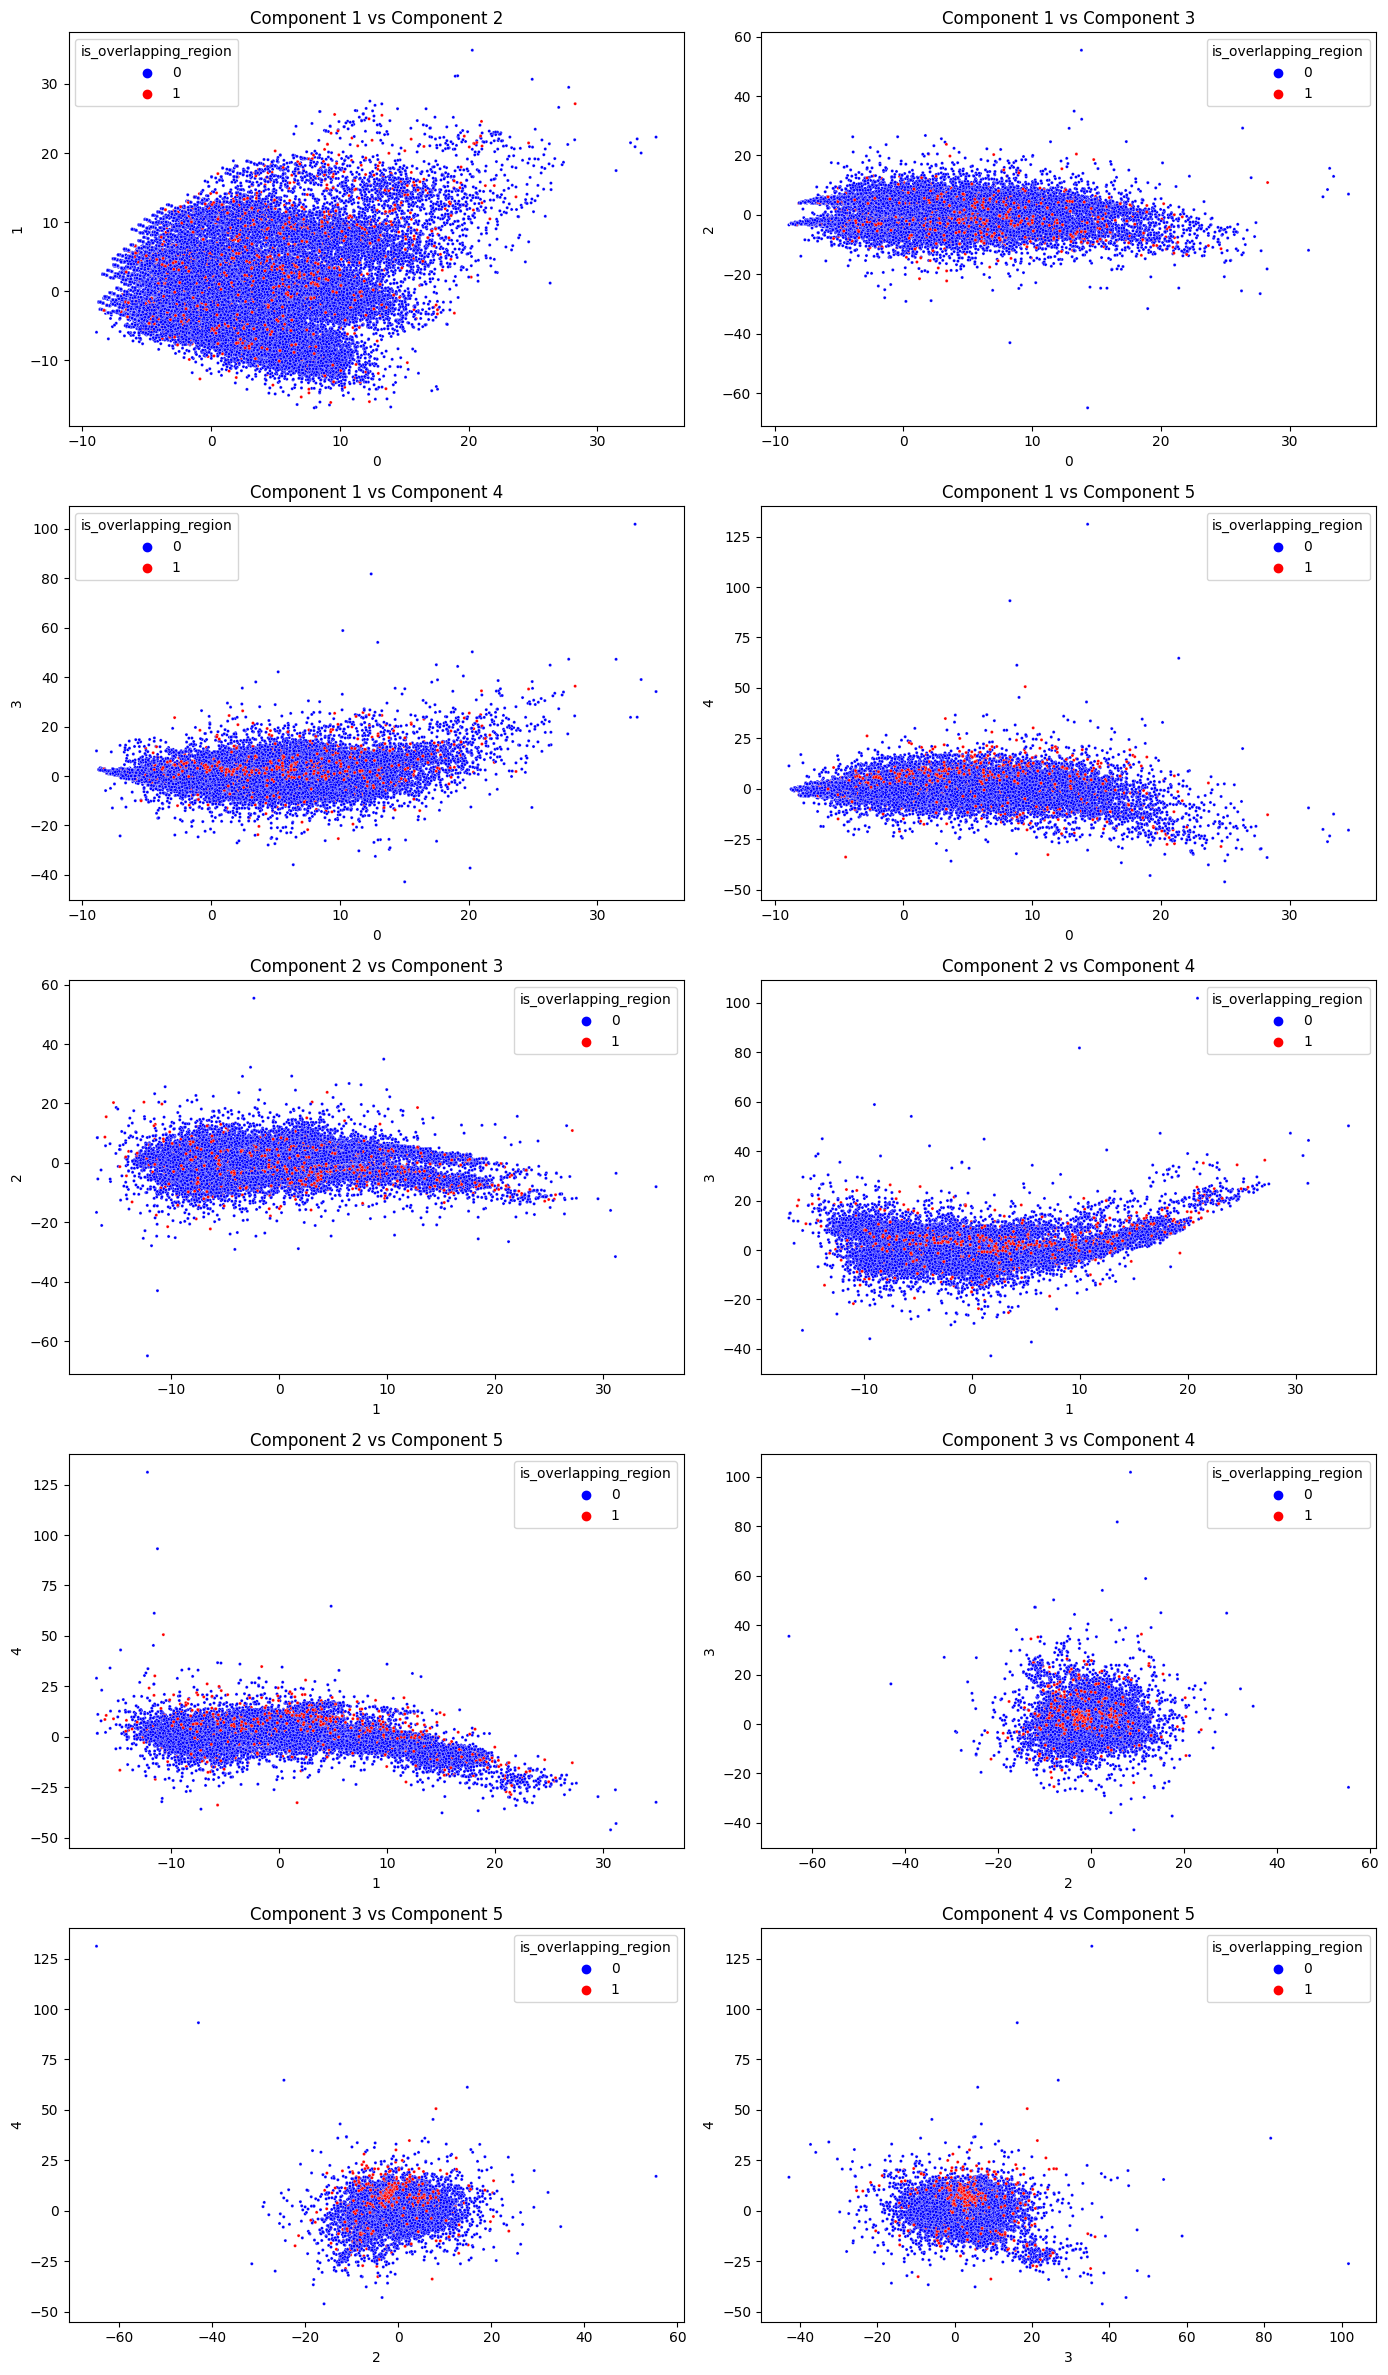

In [92]:
# Problem is that both type of instances are heavily intertwined
df5_visualization['is_overlapping_region'] = [1 if ith_neighbour == False else 0 for ith_neighbour in same_class_neighbours2]

plot_5FMDA_planes(df=df5_visualization, hue_target = 'is_overlapping_region', s_size = 5, palette = {1:'red', 0:'blue'})

It is challenging to define a equivalent region to the one defined 'locally'. However, the determination of a wider region can help in generalization problems

**Definition of overlapping regions using T1 metric**

T1 from paper Ho, T. K., & Basu, M. (2002). Complexity measures of supervised classification problems. IEEE transactions on pattern analysis and machine intelligence, 24(3), 289-300.

In [68]:
# The paper proposes the build-up of an epsilon distance of 0.55*delta
# delta is the smallest distance between two points of opposite classes

# In our case, as 1342 out of 3916 opposite-class-neighbours are at a distance of 0, we take the minimum distance 

distances_same_classes = dist2[same_class_neighbours2 == True][:,1]
distances_opposite_classes = dist2[same_class_neighbours2 == False][:,1]
delta = np.min(distances_opposite_classes[distances_opposite_classes != 0])
epsilon = 0.55*delta
epsilon

0.12075699484457131

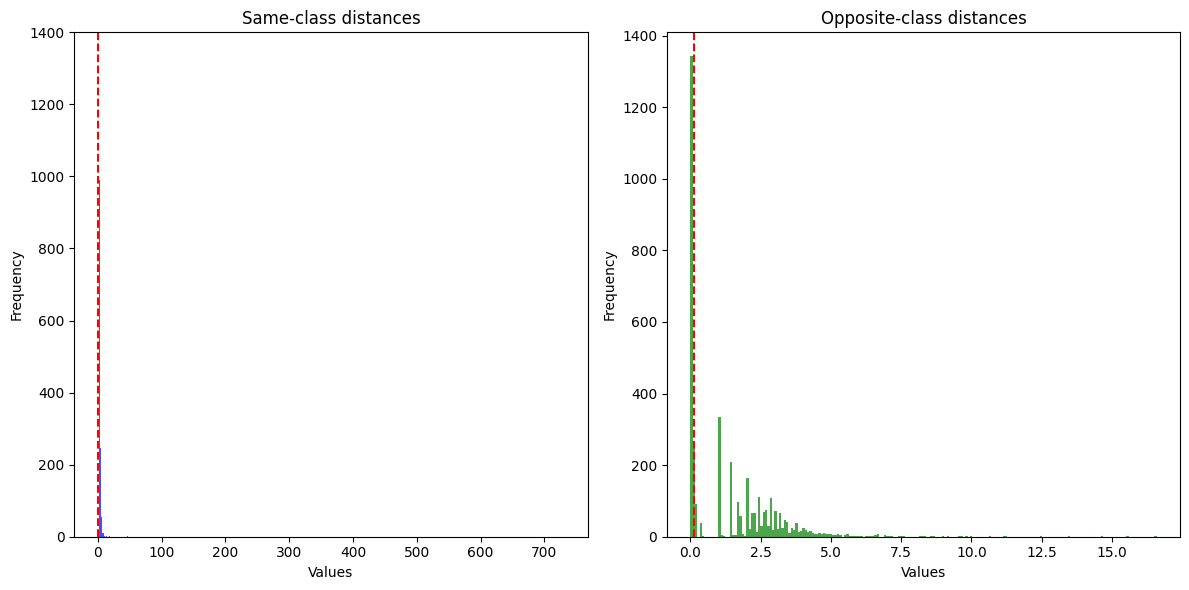

In [69]:
# Creating a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting histograms for the two arrays in separate subplots
ax1.hist(distances_same_classes[distances_same_classes < np.mean(distances_same_classes)], 
         bins=int(200*imb_ratio), color='blue', alpha=0.7)
ax2.hist(distances_opposite_classes[distances_opposite_classes < np.mean(distances_opposite_classes)], 
         bins=200, color='green', alpha=0.7)

# Show epsilon to see how many will belong closer to each other
vertical_line_x1 = epsilon
vertical_line_x2 = epsilon
ax1.axvline(x=vertical_line_x1, color='red', linestyle='--', label='Vertical Line')
ax2.axvline(x=vertical_line_x2, color='red', linestyle='--', label='Vertical Line')

# Titles and labels
ax1.set_title('Same-class distances')
ax2.set_title('Opposite-class distances')

ax1.set_xlabel('Values')
ax2.set_xlabel('Values')

ax1.set_ylabel('Frequency'); ax1.set_ylim([0, 1400])
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [52]:
# Build-up of metric T1 to define overlapping and non-overlapping regions
# 1. Determine the indices of points within a radius epislon to every other instance
# 2. Build the epsilon-neighbourhoods taking only the points with the same class within a same neighbourhood
# 3. Merge together neighbourhoods overlapping with each other
# 4. Calculate the metric T1
# 5. Check how many of the regions are purely positive and which purely negative

# 1. Points within in epsilon-distance
print('Building epsilon-distance neighbourhoods ...')
print('Around 3 mins ...')
indices_epsilon_neighbours = tree2.query_radius(X_data_dummies, r=epsilon)

# 2. same_class_neighbourhoods > in every epsilon-neighbourhood, the points belonging to different classes to the pivot instance are removed 
print('Building same-class neighbourhoods ...')
print('Around 5 mins ...')
same_class_neighbourhoods = [ind[labels[ind] == labels[i]] for i, ind in enumerate(indices_epsilon_neighbours)]

# 3. Definition of regions: merging neighbourhoods together
print('Building regions from same-class neighbourhoods overlapping with each other ...')
print('This may take up to 30 mins ...')

regions = []
for neighbourhood in same_class_neighbourhoods:
    neighbourhood_set = set(neighbourhood)
    # Check if neighbourhood overlaps with any existing region
    # If it overlaps, merge it with the overlapping region
    # Otherwise, it's a new region
    overlap = [i for i, region in enumerate(regions) if not region.isdisjoint(neighbourhood_set)]
    if overlap:
        regions[overlap[0]] = regions[overlap[0]].union(neighbourhood_set)
    else:
        regions.append(neighbourhood_set)

print('Done!')

In [92]:
# 4. Metric T1  
n_instances = df1.shape[0]
n_regions = len(regions)
T1 = n_regions / n_instances
print(f'T1 metric of dispersion of the data: {T1}')

# 5. Check how many of the regions are purely positive and which purely negative
# IMPORTANT !! We need to exclude those regions formed by one single point. These points can be considered to belong to no neighbourhood
regions_bigger_than1 = (np.array([len(area) for area in regions]) != 1)

T1 metric of dispersion of the data: 0.5931929628854958


# Additional method to differentiate overlapping vs non-overlapping regions

Steps:
1. Train-test split: have the validation data **completely hidden**
2. Overlapping classes in the training data
3. Train a discriminator on the overlapping data: it needs to be able to differentiate between overlapping and non-overlapping regions (add the distance to the closes neighbours as part of the predictors for this)
4. For the X_validation data: use the **discriminator** to determine the probability of every {x_i € X_validation} to belong to overlapping 
5. Fit two different models: overlapping and non-overlapping regions (in the training data)
6. Predict the labels on the X_validation data: y_probs_validation_overlapping_model and y_probs_validation_nonOverlapping_model
7. Establish a weighted mean where weights are the probablities dtermined in step 4. 
8. Find the optimal threshold F2 metric 

In [11]:
# 1. Train-test split: Validation data completely hidden
X = df1.drop(['RSV_test_result'], axis = 1)
y = df1.RSV_test_result

test_size = 0.1
random_seed = 42

X_data, X_validation, y_data, y_validation = train_test_split(X, y, test_size = test_size, random_state = random_seed, 
                                                              stratify = y) 

In [14]:
# 2. Overlapping instances in the training data

# Step 0: No famd transform
print('Non-famd transformed data ...')
X_data_dummies = pd.get_dummies(X_data)

# Step 2: Ball tree 
print('Build-up of the ball tree ...')

tree2 = BallTree(X_data_dummies)

# Step 3: tree-guided closest neighbour
# The closest point to every instance is itself, so k = 2 returns the point itself + the closest neighbour
# let us take 5 (4 neighbours + 1 itself) closest neighbours to help in the prediction of overlapping instances 
n_neighbours = 5

print(f'Finding closest {n_neighbours - 1} neighbour(s) in the ball tree for every instance ...')
dist2, ind2 = tree2.query(X_data_dummies, k=n_neighbours)

# Step 4: same class neighbours
print('Determination of instances with a same-class neighbour ...')

labels = y_data.to_numpy()
same_class_neighbours2 = labels[ind2[:, 0]] == labels[ind2[:, 1]]
N1_2 = 1 - np.mean(same_class_neighbours2)
print(f'N1 metric: {N1_2}')

#  Step 5: add a higher number of neighbours to evaluate a varying overlapping
same_class_neighbours_dict = {}
N1_dict = {}

for k in range(1, n_neighbours):
    # For each k, we'll check for same class neighbors across all instances
    same_class_neighbours2 = np.array([all(labels[i] == label for label in labels[ind2[j, 1:k+1]]) for j, i in enumerate(ind2[:, 0])])
    N1_metric = 1 - np.mean(same_class_neighbours2)

    same_class_neighbours_dict[k] = same_class_neighbours2
    N1_dict[k] = N1_metric 

    print(f'N1 metric for {k} neighbours : {N1_metric}')

print('Done!')

Non-famd transformed data ...
Build-up of the ball tree ...
Finding closest neighbour in the ball tree for every instance ...
Determination of instances with a same-class neighbour ...
Done!


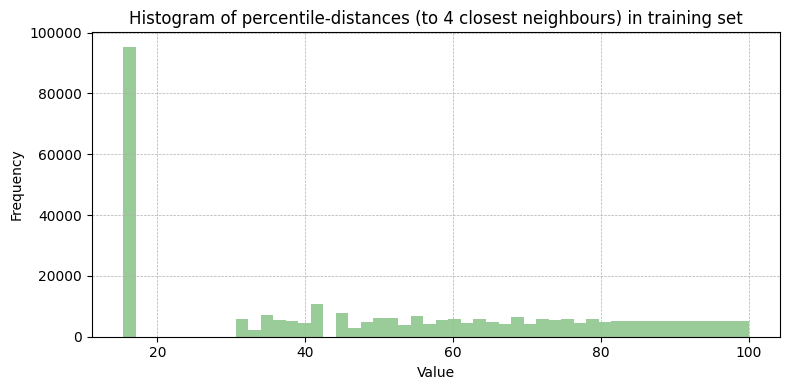

Percentile-distances df built!


In [152]:
# 3. Fit a discriminator able to differentiate between overlapping and non-overlapping instances
# This model aims to differentiate between overlapping and non-overlapping instances, remember

# Add some distance predictors to determine the overlapping or non-overlapping nature of the data
# These metrics need to be uniformized, as the validation set will have very different absolute values 
dist_to_other_points_trainingset = dist2[:,1:]

dist2_flattened = dist_to_other_points_trainingset.flatten()
percentile_distances_training_matrix = distance_matrix_to_percentile(dist_to_other_points_trainingset)
percentiles_flattened = percentile_distances_training_matrix.flatten()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

# Plot histogram for percentiles
axes.hist(percentiles_flattened, bins=50, color='green', alpha = 0.4)
axes.set_title('Histogram of percentile-distances (to 4 closest neighbours) in training set')
axes.set_xlabel('Value')
axes.set_ylabel('Frequency')
axes.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


# The actual predictors are the percentile_matrix distances

percentile_distances_training_df = pd.DataFrame(percentile_distances_training_matrix, columns = ['percentile_distance_to_neighbour_n_' + str(ii + 1) for ii in range(percentile_distances_training_matrix.shape[1])])
percentile_distances_training_df['mean_percentile_distance'] = np.mean(percentile_distances_training_matrix, axis = 1)
percentile_distances_training_df['min_percentile_distance'] = np.min(percentile_distances_training_matrix, axis = 1)
percentile_distances_training_df['max_percentile_distance'] = np.max(percentile_distances_training_matrix, axis = 1)
percentile_distances_training_df['std_percentile_distance'] = np.std(percentile_distances_training_matrix, axis = 1)

print('Percentile-distances df built!')

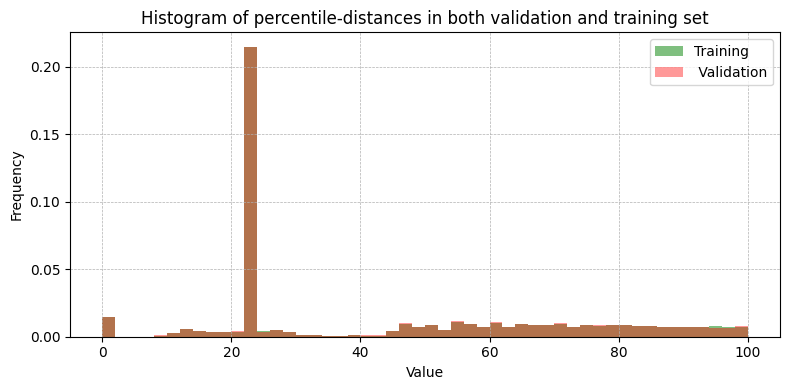

In [562]:
# 3.2. Let us compute the percentile distances of validation and training set together 

# AFTER EVALUTION OF THIS METHOD, IT DOES NOT RESULT IN AN IMPROVEMENT IN THE PERFORMANCE OF THE DISCRIMINATOR
# THIS METHOD IS THUS DISCARDED

# # Distances in the training set
# X_data_dummies = pd.get_dummies(X_data)
# same_class_neighbours_dict_data, N1_data, dist_data, ind_data = calculate_same_neighbours_and_N1(X = X_data_dummies, y = y_data, n_neighbours = 5)

# dist_to_other_points_trainingset = dist_data[:,1:]
# # Distances in the validation set
# X_validation_dummies = pd.get_dummies(X_validation)
# __, __, dist_validation, __ = calculate_same_neighbours_and_N1(X = X_validation_dummies, y = y_validation, n_neighbours = 5)

# dist_to_other_points_validation = dist_validation[:,1:]

# # Total percentile matrix
# distance_matrix_all = np.vstack([dist_to_other_points_trainingset, dist_to_other_points_validation])
# percentile_distances_all_matrix = distance_matrix_to_percentile(distance_matrix_all)

# # Percentile-distances df and feature creation
# percentile_distances_all_df = percentile_distances_df_buildup(percentile_distances_all_matrix)
# print('Percentile-distances df built!')

# # Split in the validation and test matrices
# percentile_distances_training_df = percentile_distances_all_df.loc[:(X_data.shape[0] - 1), :]
# percentile_distances_validation_df = percentile_distances_all_df.iloc[-(X_validation.shape[0]):]

# assert percentile_distances_training_df.shape[0] == X_data.shape[0], '*Training* percentile df has been INCORRECTLY defined' 
# assert percentile_distances_validation_df.shape[0] == X_validation.shape[0], '*Validation* percentile df has been INCORRECTLY defined' 


# Visualize the distributions of both validation and training percentile distances
percentiles_flattened_training = np.array(percentile_distances_training_df).flatten()
percentiles_flatenned_validation = np.array(percentile_distances_validation_df).flatten()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

axes.hist(percentiles_flattened_training, bins=50, color='green', alpha = 0.5, density = True, label = 'Training')
axes.hist(percentiles_flatenned_validation, bins=50, color='red', alpha = 0.4, density = True, label = ' Validation')

axes.set_title('Histogram of percentile-distances in both validation and training set')
axes.set_xlabel('Value')
axes.set_ylabel('Frequency')
axes.legend()
axes.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [508]:
# 3.3. Calculate the distance matrix over the whole dataset

# Distance matrix over the whole dataset
X_all = pd.concat([X_data, X_validation], axis = 0)
X_all_dummies = pd.get_dummies(X_all)

y_all = pd.concat([y_data, y_validation], axis = 0)

same_class_neighbours_dict_all, N1_all, dist_matrix_all, ind_all = calculate_same_neighbours_and_N1(X = X_all_dummies, y = y_all, n_neighbours = 5)

# Percentile_matrix_all and percentile_matrix_df_all
percentile_distances_all_matrix = distance_matrix_to_percentile(dist_matrix_all)
percentile_distances_all_df = percentile_distances_df_buildup(percentile_distances_all_matrix)

# Separate the same_class_neighbours_dict and the percentile-distance df in validation and training
len_data = X_data.shape[0]
len_validation = X_validation.shape[0]

same_class_neighbours_dict_training = {key: value[:len_data] for key, value in same_class_neighbours_dict_all.items()}
same_class_neighbours_dict_validation = {key: value[-len_validation:] for key, value in same_class_neighbours_dict_all.items()}

for key, (train_values, val_values) in zip(same_class_neighbours_dict_all.keys(), zip(same_class_neighbours_dict_training.values(), same_class_neighbours_dict_validation.values())):
    assert len(train_values) == len_data, 'Same_class_dict in TRAINING incorrectly specified'
    assert len(val_values) == len_validation, 'Same_class_dict in VALIDATION incorrectly specified'


percentile_distances_training_df = percentile_distances_all_df.loc[:(X_data.shape[0] - 1), :]
percentile_distances_validation_df = percentile_distances_all_df.iloc[-(X_validation.shape[0]):]
assert percentile_distances_training_df.shape[0] == X_data.shape[0], '*Training* percentile df has been INCORRECTLY defined' 
assert percentile_distances_validation_df.shape[0] == X_validation.shape[0], '*Validation* percentile df has been INCORRECTLY defined' 

Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.04766552789978851
N1 metric for 2 neighbours : 0.07144019149875669
N1 metric for 3 neighbours : 0.09380882660531265
N1 metric for 4 neighbours : 0.11724650816890936
Done!


In [547]:
# Let us now add these new predictors to the data of interest
# Remember !!! the goal is to predict for overlapping vs non-overlapping points
X_data = X_data.reset_index(drop = True)
percentile_distances_training_df = percentile_distances_training_df.reset_index(drop = True)
X_modelling_overlap = pd.concat([X_data, percentile_distances_training_df], axis = 1)

n_neighbours_to_determine_overlap = 3
print(f'Modelling using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')
print(f'This results in a N1 metric of: {N1_dict[n_neighbours_to_determine_overlap]}\n')

y_modelling_overlap = ['non_overlapping' if same_class_closest == True else 'overlapping' for same_class_closest in same_class_neighbours_dict_training[n_neighbours_to_determine_overlap]]

# Train-test split for accurate discriminator performance
X_train_discriminator, X_test_discriminator, y_train_discriminator, y_test_discriminator = train_test_split(
    X_modelling_overlap, y_modelling_overlap, test_size = 0.4, random_state = random_seed, stratify = y_modelling_overlap
)

X_train_discriminator = pd.get_dummies(X_train_discriminator)
X_test_discriminator = pd.get_dummies (X_test_discriminator)

# # Now, we can start building the discriminator in overlap vs non-overlap
random_seed = 42
cost_sensitive = True

if cost_sensitive:
    weight_dict = {"non_overlapping": 1,
                   "overlapping": 5} # BE CAREFUL!! Realize positives here are 'overlapping'
    discriminator = RandomForestClassifier(class_weight= weight_dict,
                                         random_state= random_seed,
                                         oob_score=False)
else:
    discriminator = RandomForestClassifier(class_weight= None,
                                         random_state= random_seed,
                                         oob_score=False)
    
param_grid = {
    'n_estimators': [14],
    'max_depth': [5, 15],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 3]
}

target_scorer = make_scorer(f1_score, average='binary', pos_label = 'overlapping')
n_cv_folds = 5

trained_discriminator = train_model_gridsearch(model_class = discriminator, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                                                X_train = X_train_discriminator, y_train = y_train_discriminator)

Modelling using as reference 3 number of neighbours to determine overlap
This results in a N1 metric of: 0.09638227547384182

Training model ... RandomForestClassifier(class_weight={'non_overlapping': 1, 'overlapping': 5},
                       random_state=42)
Best training parameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 14}
Best training f1-score:  0.4817461703092009


In [548]:
optimal_threshold = find_optimal_moving_threshold(trained_model = trained_discriminator, X_test = X_test_discriminator, y_test = y_test_discriminator,
                                                  pos_label = 'overlapping')


__,__,__,__,__,__,__,__ = calculate_performance_metrics_rsv(trained_model = trained_discriminator, X_test = X_test_discriminator, y_test = y_test_discriminator, 
                                                            threshold= optimal_threshold, print_roc = False, print_pr = False,
                                                            pos_label = 'overlapping', neg_label = 'non_overlapping')

Optimal threshold: 0.44
Optimal f1: 0.500754716981132


AUC Score: 0.8353983111643899
Precision / Positive predictive value: 0.5561609388097234
Specificity: 0.9622688566644102
Recall / sensitivity: 0.45538778311599176
Negative predictive value: 0.944500786850848
Accuracy: 0.914592814951099
F-1: 0.500754716981132
Precision-Recall AUC: 0.5320269636673678


Build-up of the ball tree ...
Finding closest 4 neighbour(s) in the ball tree for every instance ...
Determination of instances with same-class neighbours ...
N1 metric for 1 neighbours : 0.050429932605159156
N1 metric for 2 neighbours : 0.07413432488961191
N1 metric for 3 neighbours : 0.095166163141994
N1 metric for 4 neighbours : 0.11596560539158729
Done!


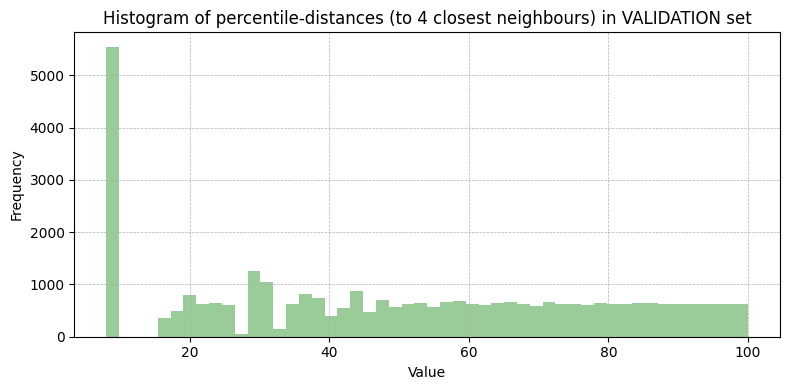

In [479]:
# 4. Calculate probabilities/weights on the X_validation
# Now that the discriminator is built, we can calculate the probabilities of X_validation belonging to a overlapping or non-overlapping region

# # 4.1. Percentile_distances build-up for X_Validation
# X_validation_dummies = pd.get_dummies(X_validation)
# # y_validation should NOT be accessed

# same_class_dict_validation, __, distance_matrix_validation, __ = calculate_same_neighbours_and_N1(X = X_validation_dummies, y = y_validation)
# ### BE CAREFUL! WE CANNOT USE THE same_class_neighbours_dict FOR VALIDATION DATA AS WE DO NOT HAVE ACCESS TO THE LABELS

# dist_to_other_points_validationset = distance_matrix_validation[:,1:]

# dist2_flattened = dist_to_other_points_validationset.flatten()
# percentile_distances_validation_matrix = distance_matrix_to_percentile(dist_to_other_points_validationset)
# percentiles_flattened = percentile_distances_validation_matrix.flatten()

# # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

# # Plot histogram for percentiles
# axes.hist(percentiles_flattened, bins=50, color='green', alpha = 0.4)
# axes.set_title('Histogram of percentile-distances (to 4 closest neighbours) in VALIDATION set')
# axes.set_xlabel('Value')
# axes.set_ylabel('Frequency')
# axes.grid(True, which='both', linestyle='--', linewidth=0.5)

# plt.tight_layout()
# plt.show()


# # The actual predictors are the percentile_matrix distances

# percentile_distances_validation_df = pd.DataFrame(percentile_distances_validation_matrix, columns = ['percentile_distance_to_neighbour_n_' + str(ii + 1) for ii in range(percentile_distances_validation_matrix.shape[1])])
# percentile_distances_validation_df['mean_percentile_distance'] = np.mean(percentile_distances_validation_matrix, axis = 1)
# percentile_distances_validation_df['min_percentile_distance'] = np.min(percentile_distances_validation_matrix, axis = 1)
# percentile_distances_validation_df['max_percentile_distance'] = np.max(percentile_distances_validation_matrix, axis = 1)
# percentile_distances_validation_df['std_percentile_distance'] = np.std(percentile_distances_validation_matrix, axis = 1)

In [549]:
# 4.2. Probabilities/weights computation
# Now, possible to build up the X_validation_overlapping
X_validation = X_validation.reset_index(drop = True)
percentile_distances_validation_df = percentile_distances_validation_df.reset_index(drop = True)
X_validation_overlap = pd.concat([X_validation, percentile_distances_validation_df], axis = 1)

X_validation_overlap = pd.get_dummies(X_validation_overlap)

probs_of_overlapping_validation = trained_discriminator.predict_proba(X_validation_overlap)[:,1]


# If wanted, we can plot the probabilities (and consecutive weights of being part of the overlapping region)
# # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

# # Plot histogram for percentiles
# axes.hist(probs_of_overlapping, bins=20, color='blue', alpha = 0.4)
# axes.set_title('Histogram of probabilities to be part of the overlapping region-VALIDATION set')
# axes.set_xlabel('Value')
# axes.set_ylabel('Frequency')
# axes.grid(True, which='both', linestyle='--', linewidth=0.5)

# plt.tight_layout()
# plt.show()

In [550]:
# 4.3 Evaluating the performance of the discriminator (on the validation set)
labels_overlapping_validation = ['overlapping' if same_class_neighbour_ith == False else 'non_overlapping' for same_class_neighbour_ith in same_class_dict_validation[1]]
# probs_of_overlapping_validation

best_threshold_overlapping = None
best_performance_metric = float('-inf')

for threshold_val in np.arange(0.05, 0.96, 0.01):

    overlapping_mask_0 = probs_of_overlapping_validation > threshold_val
    overlapping_mask = ['overlapping' if prob == True else 'non_overlapping' for prob in overlapping_mask_0]

    metric = f1_score(labels_overlapping_validation, overlapping_mask, pos_label = 'overlapping')

    if metric > best_performance_metric:
        best_performance_metric = metric
        best_threshold_overlapping = threshold_val

print("Best threshold for overlapping validation:", best_threshold_overlapping)
print("Best F1 metric (of the discriminator of overlap vs non overlap):", best_performance_metric) 

Best threshold for overlapping validation: 0.37000000000000005
Best F1 metric (of the discriminator of overlap vs non overlap): 0.24316939890710387


In [551]:
# 5. Fit of TWO independent models (one in the overlapping and one in the non-overlapping regions) in the TRAINING SET
print('\n------------------')
print('-------------------')
print('Fitting model on trainig data exclusively')
print(f'Building the two models using as reference {n_neighbours_to_determine_overlap} number of neighbours to determine overlap')

model_nonOverlapping, model_Overlapping = only_build_2overlapping_models(X = X_data, labels = y_data, same_class_neighbors = same_class_neighbours_dict_training[n_neighbours_to_determine_overlap], 
                                                                        random_seed = 42,
                                                                        model_class_non_overlapping = RandomForestClassifier(),
                                                                        param_grid_non_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_non_overlapping = False, weight_dict_non_overlapping = {'Negative': 1, 'Positive': 15},
                                                                        model_class_overlapping = RandomForestClassifier(),
                                                                        param_grid_overlapping = {'n_estimators': [7, 14],'max_depth': [10, 20],'min_samples_split': [5, 10],'min_samples_leaf': [1, 4]},
                                                                        cost_sensitive_overlapping = False, weight_dict_overlapping = {'Negative': 1, 'Positive': 15})



------------------
-------------------
Fitting model on trainig data exclusively
Building the two models using as reference 3 number of neighbours to determine overlap
----------------
Building non-overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.5722046861267367
----------------
Building (yes) overlapping model ...
Training model ... RandomForestClassifier(random_state=42)
Best training parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 7}
Best training f1-score:  0.327444951217102


In [552]:
# 6. For X_validation, predict the probabilities of being Positive/Negative test
X_validation_dummies = pd.get_dummies(X_validation)

# 6.1 y_probs_validation_nonOverlapping_model 
y_probs_validation_nonOverlapping_model = model_nonOverlapping.predict_proba(X_validation_dummies)[:,1]

# 6.2. y_probs_validation_overlapping_model
y_probs_validation_Overlapping_model = model_Overlapping.predict_proba(X_validation_dummies)[:,1]


In [553]:
# 7. y_probs = weighted mean of probabilities of the overlapping and non-overlapping methods
y_probs_weighted_all = (probs_of_overlapping_validation * y_probs_validation_Overlapping_model) +  ((1-probs_of_overlapping_validation) * y_probs_validation_nonOverlapping_model)


In [554]:
# 8. Evaluate the model 

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs = y_probs_weighted_all, y_test = y_validation) 

__, __, __, __, __, __, __, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_weighted_all, y_test = y_validation, 
                                                                        threshold= optimal_threshold, print_roc = False, print_pr = False)

Optimal threshold: 0.41000000000000003
Optimal f1: 0.3869047619047619


AUC Score: 0.7336550750667876
Precision / Positive predictive value: 0.9154929577464789
Specificity: 0.9992806617911522
Recall / sensitivity: 0.24528301886792453
Negative predictive value: 0.9765670767428236
Accuracy: 0.9760632117127586
F-1: 0.3869047619047619
Precision-Recall AUC: 0.33671044310856285


In [569]:
help(calculate_performance_metrics_from_probas)

Help on function calculate_performance_metrics_from_probas in module auxFuns.modelling:

calculate_performance_metrics_from_probas(y_probs, y_test, threshold=0.5, print_roc=False, print_pr=False, ICLL=False, verbose=True)
    Calculates performance metrics for the RSV phase 1 modelling stage based on the trained model's predictions.
    
    Parameters:
    - y_probs (nd-array): The probabilities for 'Positive' label of the trained model
    - y_test (pd.Series): The testing labels.
    - threshold (int): decision threshold for the binary classification
    - print_roc (boolean): Whether to print the ROC curve. Defaults to False.
    - print_pr (boolean): Whether to print the precision-recall curve. Defaults to False.
    
    Returns:
    - auc_score (float): The Area Under the ROC Curve .
    - precision (float): Precision or Positive Predictive Value.
    - recall (float): Recall or Sensitivity.
    - specificity (float): Specificity.
    - npv (float): Negative Predictive Value.
  

In [577]:
# 9. Performance is not good, mainly because the discriminator's performance is not good
# 
# 9.1 Moving threshold for overlapping/non overlapping in the validation set
# Let us find an alternative method, where:
# - NO weighted sum of probabilities
# - Points in the validation set are either OVERLAPPING or NON-OVERLAPPING
# - There will be a threshold to determine this overtlapping or not, that we will OPTIMIZE

best_threshold_overlapping = None
best_performance_metric = float('-inf')
for threshold_val in np.arange(0.05, 0.96, 0.05):

    overlapping_mask = probs_of_overlapping_validation > threshold_val
    y_probs_all = (overlapping_mask * y_probs_validation_Overlapping_model) + ((~overlapping_mask) * y_probs_validation_nonOverlapping_model)

    optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_validation, verbose = False)
    
    __, prec, recall, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_validation, 
                                                                        threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = False)

    if f1 > best_performance_metric:
        best_performance_metric = f1
        best_threshold_overlapping = threshold_val
        best_recall = recall
        best_prec = prec


print("Best threshold for overlapping validation:", best_threshold_overlapping)
print("Best performance metric (f1) for RSV-positivity model:", best_performance_metric)     
print("Associated recall:", best_recall)        
print("Associated precision:", best_prec)           

Best threshold for overlapping validation: 0.7000000000000001
Best performance metric (f1) for RSV-positivity model: 0.4
Associated recall: 0.27547169811320754
Associated precision: 0.73


In [582]:
# 9.2 (check that the performance of the model is optimal with the true overlapping mask)
true_overlapping_mask = ~same_class_dict_validation[1]
y_probs_all = (true_overlapping_mask * y_probs_validation_Overlapping_model) + ((~true_overlapping_mask) * y_probs_validation_nonOverlapping_model)

optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs=y_probs_all, y_test=y_validation, verbose = True)

__, __, __, __, __, __, f1, __ = calculate_performance_metrics_from_probas(y_probs = y_probs_all, y_test = y_validation, 
                                                                    threshold= optimal_threshold, print_roc = False, print_pr = False, verbose = True)


Optimal threshold: 0.1
Optimal f1: 0.6288492706645057


AUC Score: 0.9557150063451059
Precision / Positive predictive value: 0.5511363636363636
Specificity: 0.9810574271670064
Recall / sensitivity: 0.7320754716981132
Negative predictive value: 0.9913981100072692
Accuracy: 0.9733906576806879
F-1: 0.6288492706645057
Precision-Recall AUC: 0.654453210149284


In [580]:
# 9.3 Assign a weight for the probabiliteis of overlapping proportional to the imbalance ratio between overlapping and non-overlapping instances
# AugN1 = (1/(imb_ratio + 1)) * (N1_majority + imb_ratio*N1_minority)

best_threshold_overlapping = None
best_performance_metric = float('-inf')

imb_ratio_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 5, 7, 10, 15]
a_overlapping = (probs_of_overlapping_validation * y_probs_validation_Overlapping_model)
b_non_overlapping = ((1-probs_of_overlapping_validation) * y_probs_validation_nonOverlapping_model)

for imb_ratio in imb_ratio_values:
    y_probs_weighted_all =  (1/(imb_ratio + 1)) * (imb_ratio*a_overlapping + b_non_overlapping)  


    optimal_threshold = find_optimal_moving_threshold_from_probas(y_probs = y_probs_weighted_all, y_test = y_validation, verbose = False) 
    
    __, prec, recall, __, __, __, f1, __ =  calculate_performance_metrics_from_probas(y_probs = y_probs_weighted_all, y_test = y_validation, 
                                                                        threshold= optimal_threshold, print_roc = False, print_pr = False,  verbose = False)

    if f1 > best_performance_metric:
        best_performance_metric = f1
        best_imbratio = imb_ratio
        best_recall = recall
        best_prec = prec


print("Best threshold for overlapping validation:", best_imbratio)
print("Best performance metric (f1) for RSV-positivity model:", best_performance_metric)     
print("Associated recall:", best_recall)        
print("Associated precision:", best_prec)  


Best threshold for overlapping validation: 0.8
Best performance metric (f1) for RSV-positivity model: 0.38616714697406335
Associated recall: 0.2528301886792453
Associated precision: 0.8170731707317073
